In [60]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../scripts')
from load_data import LoadData
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from datetime import datetime

## Loading the data into dataframes

In [35]:
train_df = pd.read_csv('../data/train.csv')
train_df.head()

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [36]:
test_df = pd.read_csv('../data/test.csv')
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [37]:
store_df = pd.read_csv('../data/store.csv')
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Merging the data

In [38]:
combined_train_df = pd.merge(train_df, store_df, on='Store')
combined_test_df = pd.merge(test_df, store_df, on='Store')
combined_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


### Focus on the sales made on each day

In [70]:
sales = pd.DataFrame(combined_train_df[['Date','Sales', 'Open', 'Promo', 'Customers']])
sales.head()

,Date,Sales,Open,Promo,Customers
0,2015-07-31,5263,1,1,555
1,2015-07-30,5020,1,1,546
2,2015-07-29,4782,1,1,523
3,2015-07-28,5011,1,1,560
4,2015-07-27,6102,1,1,612


In [71]:
sales['Date'] = pd.to_datetime(sales['Date'])
sales = sales.set_index('Date')
sales.head()

,Sales,Open,Promo,Customers
Date,,,,
2015-07-31,5263,1,1,555
2015-07-30,5020,1,1,546
2015-07-29,4782,1,1,523
2015-07-28,5011,1,1,560
2015-07-27,6102,1,1,612


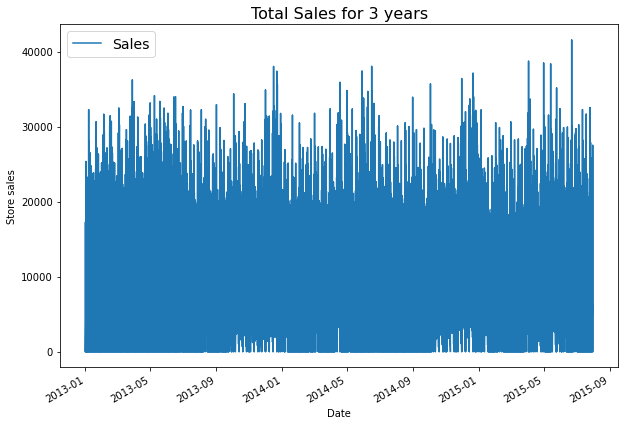

In [73]:
sales['Sales'].plot(figsize=(10, 7))
plt.ylabel("Store sales")
plt.title("Total Sales for 3 years", fontsize=16)
plt.legend(fontsize=14);

### Splitting the data into test and train sets

In [74]:
# Get sales date array
timesteps = sales.index.to_numpy()
total_sales = sales["Sales"].to_numpy()

In [75]:
split_size = int(0.8 * len(sales)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], total_sales[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], total_sales[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(813767, 203442, 813767, 203442)

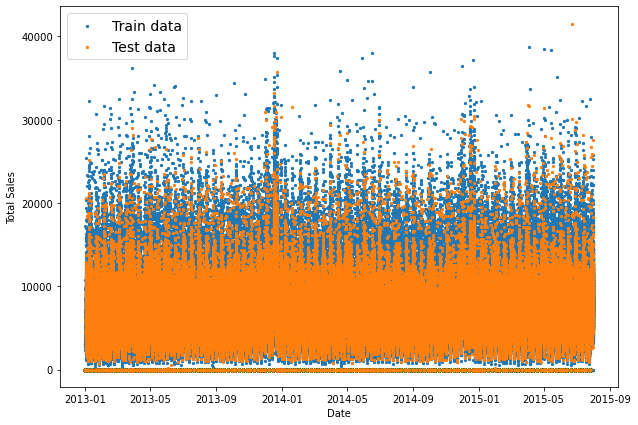

In [76]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend(fontsize=14)
plt.show();

In [77]:
pipeline_lr = Pipeline([('scaler1', StandardScaler()), ('lr_classifier', LogisticRegression(random_state=123))])

In [78]:
pipeline_rr = Pipeline([('scaler2', StandardScaler()), ('rf_classifier', RandomForestRegressor())])

In [79]:
pipeline_dt = Pipeline([('scaler3', StandardScaler()), ('dt_classifier', DecisionTreeClassifier())])

### Comparing the accuracy of our models

In [80]:
# Create a   list of pipeline in order to compare the accuracy of each pipeline
pipelines = [pipeline_lr, pipeline_rr, pipeline_dt]

In [81]:
best_accuracy = 0.0
best_classifier = 0
best_pipeline = ''

In [84]:
#Create a dictioary of pipelines and classifier types for easy referencing
pipe_dict = { 1: 'Random Forest Regression', 2: 'Decision Tree'}

#Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

ValueError: Expected 2D array, got 1D array instead:
array=[1.4383008e+18 1.4382144e+18 1.4381280e+18 ... 1.3909536e+18 1.3908672e+18
 1.3907808e+18].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.